## This notebook contains NMT implementation (Machine translation i.e italian to english or english to italian translation)

It uses global attention with general, concat and dot products for measuring similarity between encoder and decoder states.The notebook also contains a vanilla implementation of machine translation

In [ ]:
import psutil
def get_size(bytes, suffix="B"):
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor
print("="*40, "Memory Information", "="*40)
svmem = psutil.virtual_memory()
print(f"Total: {get_size(svmem.total)}") ; print(f"Available: {get_size(svmem.available)}")
print(f"Used: {get_size(svmem.used)}") ; print(f"Percentage: {svmem.percent}%")

======================================== Memory Information ========================================
Total: 25.51GB
Available: 21.57GB
Used: 4.42GB
Percentage: 15.4%


# GPU Information

In [ ]:
! nvidia-smi

Sun Jul  5 08:41:57 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    39W / 250W |  15561MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **Sequence to sequence implementation**</font>

1. Download the **Italian** to **English** translation dataset from <a href="http://www.manythings.org/anki/ita-eng.zip">here</a>

2. You will find **ita.txt** file in that ZIP, 
you can read that data using python and preprocess that data. 

3. We  implement an Encoder and Decoder architecture with  
attention

    * Encoder   - with 1 layer LSTM <br>
    * Decoder   - with 1 layer LSTM<br>
    * attention 

4. In Global attention, we have 3 types of scoring functions
<img src='https://i.imgur.com/iD2jZo3.png'>

    * In model 1 we implemnt "dot" score function
    * In model 2 we implement "general" score function
    * In model 3 we implemnt "concat" score function.<br>
    

In [ ]:
## Importing Necessary 

import tensorflow as tf
from tensorflow.keras.layers import Input, Softmax, RNN, Dense, Embedding, LSTM, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')
import nltk.translate.bleu_score as bleu
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import random
import unicodedata
import re
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir( '/content/drive/My Drive' )
os.getcwd()

'/content/drive/My Drive'

### Load the Data


In [ ]:
# !wget --header="Host: www.manythings.org" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.116 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://colab.research.google.com/" --header="Cookie: __cfduid=d16fa2cd8fc38b9f700c89cf62b5a453e1593506556" --header="Connection: keep-alive" "http://www.manythings.org/anki/ita-eng.zip" -c -O 'ita-eng.zip'
# !wget --header="Host: doc-0c-a0-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.116 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://drive.google.com/drive/u/0/my-drive" --header="Cookie: AUTH_4kuvt6cr8mgl7rbuvadsnm96cct15t8d_nonce=9hrilv2239ajo" --header="Connection: keep-alive" "https://doc-0c-a0-docs.googleusercontent.com/docs/securesc/7c6p71ehou2ekpfv4iujgdqu0876c9sf/156aumu2kar38qfcmj0sjljcrnp8jsdg/1593751725000/05123619362948744171/05123619362948744171/1-3Kqf0zJFQu7f6KEgcfsHL7Ru57QMtnb?e=download&authuser=0&nonce=9hrilv2239ajo&user=05123619362948744171&hash=96mq8363hh1sevil998f0uesabiea84h" -c -O 'ita.txt'

In [ ]:
with zipfile.ZipFile("/content/drive/My Drive/ita-eng.zip","r") as zip_ref:
  zip_ref.extractall(  )

### Preprocessing


In [ ]:
with open( '/content/drive/My Drive/ita.txt' , 'r') as file:
  data = file.readlines()
  hold_data = []
  hold_english = []
  hold_italian = []
  cleaned_eng = []
  cleaned_ita = []
  for every in data:
    hold_data.append(   every.split('\t')[ : 2 ]    )
    hold_english.append(  every.split( '\t' )[ 0 ]  )
    hold_italian.append(  every.split( '\t' )[ 1 ] )
  cleaned_eng = [  re.sub(  r'([!.?])' ,  r' \1',  every    )   for every in hold_english  ] 
  cleaned_ita = [  re.sub(  r'([!.?])' ,  r' \1',  every    )   for every in hold_italian  ]

In [ ]:
def unicode_to_ascii(s):
    ''' Input :: Takes in a string .
        outputs :: the string after unicode to ascii ( as there are characters which do not belong in ascii set)
    '''
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

In [ ]:
def normalize_string(s):
    ''' Input :: Takes in a string , adds spaces between punctuations such as comma, period, question mark etcc...
        returns the modified string
    '''
    s = unicode_to_ascii(s)
    s = re.sub(r'([!.?])', r' \1', s)
    s = re.sub(r'[^a-zA-Z.!?]+', r' ', s)
    s = re.sub(r'\s+', r' ', s)
    return s

In [ ]:
enc_in = [ normalize_string( word) for word in cleaned_eng ]   # Input for encoder
enc_in[ : 3 ]

['Hi .', 'Run !', 'Run !']

In [ ]:
dec_ita_in = ['<start> ' + normalize_string(word) for word  in cleaned_ita]  # Give this to decoder input
dec_ita_out = [  normalize_string(word) + ' <end>' for word in cleaned_ita] #  This is what must be actual decoder output 

In [ ]:
dec_ita_in[:3]

['<start> Ciao !', '<start> Corri !', '<start> Corra !']

In [ ]:
dec_ita_out[ : 3]

['Ciao ! <end>', 'Corri ! <end>', 'Corra ! <end>']

In [ ]:
# Here We are Tokenizing english sentences  with no filters  and this is the fed into the encoder 

tok_eng = tf.keras.preprocessing.text.Tokenizer( filters='' )
tok_eng.fit_on_texts( enc_in )
print( 'Sample English word Dictionary  :: ',  list(tok_eng.word_index.items() )[ : 5]  )

seq_eng  =  tok_eng.texts_to_sequences( enc_in )
print( 'Sample Encoder input after converting it into  texts to word sequences  based on dictionary:: ' , seq_eng[ :5]  )
print( 'Sample encoder input  with sentence :: \n' , enc_in[0] ,  seq_eng[ 0 ] , sep = '\n')

Sample English word Dictionary  ::  [('.', 1), ('i', 2), ('you', 3), ('tom', 4), ('to', 5)]
Sample Encoder input after converting it into  texts to word sequences  based on dictionary::  [[2429, 1], [536, 171], [536, 171], [536, 171], [78, 6]]
Sample encoder input  with sentence :: 

Hi .
[2429, 1]


In [ ]:
seq_eng_pad = tf.keras.preprocessing.sequence.pad_sequences( seq_eng  ,  padding = 'post' , truncating = 'post' )       
# By default it takes in Max length which is 49 words
print( 'Sample Encoder input sequence after padding it with Zeros :: \n' , seq_eng_pad[ : 3] )

Sample Encoder input sequence after padding it with Zeros :: 
 [[2429    1    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [ 536  171    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [ 536  171    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]]


In [ ]:
# Here we are tokenizing Italian sentences  and  a part of these sentences are fed into the decoder

tok_ita = tf.keras.preprocessing.text.Tokenizer( filters='' )
tok_ita.fit_on_texts( dec_ita_in )
tok_ita.fit_on_texts( dec_ita_out )

print( 'Sample Italian word Dictionary  :: ',  list(tok_ita.word_index.items() )[ : 5]  )

dec_seq_ita_in = tok_ita.texts_to_sequences(  dec_ita_in  )
dec_seq_ita_out = tok_ita.texts_to_sequences(  dec_ita_out  )

print( 'Sample decoder input and output sequences with sentence :: \n' , dec_ita_in[0] , dec_ita_out[ 0 ] , dec_seq_ita_in[ 0 ] , dec_seq_ita_out [ 0 ] , sep = '\n')

Sample Italian word Dictionary  ::  [('.', 1), ('<start>', 2), ('<end>', 3), ('tom', 4), ('?', 5)]
Sample decoder input and output sequences with sentence :: 

<start> Ciao !
Ciao ! <end>
[2, 4049, 130]
[4049, 130, 3]


In [ ]:
dec_seq_ita_in_pad =  tf.keras.preprocessing.sequence.pad_sequences( dec_seq_ita_in   ,  padding = 'post' , truncating = 'post' )      
dec_seq_ita_out_pad =  tf.keras.preprocessing.sequence.pad_sequences( dec_seq_ita_out  ,  padding = 'post' , truncating = 'post' )      

In [ ]:
len( seq_eng_pad[0]) ,  len( dec_seq_ita_in_pad [ 0] ) ,  len( dec_seq_ita_out_pad [ 0] ) 

(49, 53, 53)

### Encoder Class


In [ ]:
class Encoder(tf.keras.Model):         # tf.keras.Model
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''
    def __init__( self , inp_vocab_size , embedding_size ,  lstm_size , input_length ):
      super( Encoder, self).__init__()      
      
      self.lstm_size = lstm_size
      self.embedding = tf.keras.layers.Embedding( inp_vocab_size , embedding_size, 
                                                                                      input_length = input_length, name = 'encoder_embedding_layer' , trainable = True)
      self.lstm = tf.keras.layers.LSTM (  lstm_size , return_sequences = True , return_state = True , name = 'encoder_Lstm_layer')

    def call(  self,  input_sequence ,  states):
      '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          returns -- All encoder_outputs, last time steps hidden and cell state
      '''
      embedding_lr = self.embedding( input_sequence )
      output_sequence, final_state_hidden , final_state_cell = self.lstm(  embedding_lr , initial_state = states )
      return output_sequence , final_state_hidden, final_state_cell

    def initialize_states( self ,  batch_size ):
      '''
      Given a batch size it will return intial hidden state and intial cell state.
      If batch size is 32- Hidden state shape is [32,lstm_units], cell state shape is [32,lstm_units]
      '''
      init_hidden = tf.zeros(  [ batch_size , self.lstm_size ] , dtype = 'float32' )                   # Initialize zeros as initial hidden and cell states  
      init_cell  =  tf.zeros(  [ batch_size , self.lstm_size ], dtype= 'float32' )
    
      # init_hidden = tf.random.normal( shape =  [batch_size , self.lstm_size  ]  )               # Can initialize initial hidden and cell state from any distribution
      # init_cell = tf.random.normal( shape =  [batch_size , self.lstm_size  ]  ) 
    
      return init_hidden, init_cell

<font color='cyan'>**Grader function - 1**</font>

In [ ]:
def grader_check_encoder():
    vocab_size=10
    embedding_size=20
    lstm_size=32
    input_length=10
    batch_size=16
    encoder=Encoder(vocab_size,embedding_size,lstm_size,input_length)
    input_sequence=tf.random.uniform(shape=[batch_size,input_length],maxval=vocab_size,minval=0,dtype=tf.int32)
    initial_state=encoder.initialize_states(batch_size)
    encoder_output,state_h,state_c=encoder(input_sequence,initial_state)
    
    assert(encoder_output.shape==(batch_size,input_length,lstm_size) and state_h.shape==(batch_size,lstm_size) and state_c.shape==(batch_size,lstm_size))
    return True
print(grader_check_encoder())

True


### Attention Class


In [ ]:
class Attention(  tf.keras.layers.Layer  ):           # tf.keras.layers.Layer          tf.keras.Model  
  '''
    Class the calculates score based on the scoring_function using Bahdanu attention mechanism.
  '''
  def __init__(self,scoring_function, att_units):
    super(Attention, self).__init__()
    self.att_units = att_units                                                  
    self.scoring_function = scoring_function      # Scoring function either dot, general  or concat.

    if scoring_function == 'general':
      self.W_alpha = Dense(  self.att_units  )
      
    elif scoring_function == 'concat':
      self.W_alpha = Dense( self.att_units , activation = 'tanh')
      self.V_alpha = Dense( 1 )

  def call(  self  ,  decoder_hidden_state  ,  encoder_output):
    '''
      Attention mechanism takes two inputs current step -- decoder_hidden_state and all the encoder_outputs.
      * Based on the scoring function we will find the score or similarity between decoder_hidden_state and encoder_output.
        Multiply the score function with your encoder_outputs to get the context vector.
        Function returns context vector and attention weights(softmax - scores)
    '''

    if self.scoring_function == 'dot':      
      decoder_hidden_state = tf.reshape(  decoder_hidden_state , shape = (decoder_hidden_state.shape[ 0 ], 1 ,  decoder_hidden_state.shape[ 1 ]  )  )
      score = tf.matmul(  decoder_hidden_state  , encoder_output  ,   transpose_b=True   )
        
    elif self.scoring_function == 'general' :
      decoder_hidden_state = tf.reshape(  decoder_hidden_state , shape = (decoder_hidden_state.shape[ 0 ], 1 ,  decoder_hidden_state.shape[ 1 ]  )  )
      score = tf.matmul(   decoder_hidden_state   ,   self.W_alpha(    encoder_output    )     , transpose_b=True     )
      
        
    elif self.scoring_function == 'concat':
      decoder_hidden_state = tf.reshape(  decoder_hidden_state , shape = (decoder_hidden_state.shape[ 0 ], 1 ,  decoder_hidden_state.shape[ 1 ]  )  )
      # We have to do broadcasting on the decoder's hidden state in order to match the shapes 
      decoder_hidden_state = tf.tile( decoder_hidden_state , [1, encoder_output.shape[ 1 ]  , 1  ])   
      # Concat operation done along the column dimension , meaning we added more columns.
      score = self.V_alpha(    self.W_alpha (  tf.concat(  (  decoder_hidden_state  ,   encoder_output  )  , axis = -1  )   )   )
      # Transpose it to meet  requirements
      score = tf.transpose(score, [0, 2, 1])
        
    attention_weights = tf.nn.softmax(score, axis  =  2 )       # Along  2nd axis .!
    context_vector = tf.matmul(  attention_weights , encoder_output)          # Calculate the context vector 

    # Reshape Context and alignment vectors to required shape 
    context_vector = tf.reshape ( context_vector , shape = ( context_vector.shape[ 0 ], context_vector.shape[ 2 ]  )  )
    attention_weights = tf.reshape( attention_weights , shape = ( attention_weights.shape[ 0 ] , attention_weights.shape[ 2  ] , attention_weights.shape[ 1 ] ) )

    return context_vector , attention_weights

<font color='cyan'>**Grader function - 2**</font>

In [ ]:
def grader_check_attention(scoring_fun):
    input_length=10
    vocab_size=10
    batch_size=16
    att_units=32
    state_h=tf.random.uniform(shape=[batch_size,att_units])
    encoder_output=tf.random.uniform(shape=[batch_size, input_length, att_units])
    attention=Attention(scoring_fun,att_units)
    context_vector,attention_weights=attention(state_h,encoder_output)
    assert(context_vector.shape == ( batch_size ,  att_units ) and attention_weights.shape == ( batch_size , input_length ,1) )
    return True

print(grader_check_attention('dot'))
print(grader_check_attention('general'))
print(grader_check_attention('concat'))

True
True
True


### One-Step Decoder Class

In [ ]:
class One_Step_Decoder(tf.keras.Model):
    ''' Performs the decoder operation for a Single Time step, returns the hidden, cell states and the output
    '''
  def __init__( self ,  tar_vocab_size  , embedding_dim , input_length  , dec_units ,  score_fun  , att_units  ):
    super(One_Step_Decoder, self).__init__()

    self.att_units = att_units
    self.score_fun = score_fun
    self.input_length = input_length
    self.dec_units = dec_units
    self.attention = Attention( scoring_function = self.score_fun , att_units = self.att_units  )
    
    self.dec_embedding = tf.keras.layers.Embedding( tar_vocab_size , embedding_dim , 
                                                                                            input_length = self.input_length , name = 'one_step_Decoder_embedding' , trainable = True) 
    self.dec_lstm = tf.keras.layers.LSTM (  self.dec_units , return_sequences = True , return_state = True , name = 'one_step_Decoder_lstm'  )
    self.dense_layer = Dense(tar_vocab_size , name = 'one_step_decoder_Dense' )


  def call(self , input_to_decoder, encoder_output, state_h, state_c):
    '''
        One step decoder mechanisim step by step:
      A. Pass the input_to_decoder to the embedding layer and then get the output(1,1,embedding_dim)    
      B. Using the encoder_output and decoder hidden state, compute the context vector.
      C. Concat the context vector with the step A output
      D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
      E. Pass the decoder output to dense layer(vocab size) and store the result into output.
      F. Return the states from step D, output from Step E, attention weights from Step -B
    '''
    embedding_output = self.dec_embedding(  input_to_decoder  )   # Get the embedding representations and the context vector 
    context_vector, attention_weights = self.attention( state_h , encoder_output )
    
    context_vector_after_reshaping = tf.reshape( tensor = context_vector , shape =  ( context_vector.shape[ 0 ], 1, context_vector.shape[ 1 ]  ) )
    
    # Now concatenate both embedding output and the context vector 
    concat_A_and_C = tf.concat(  [ embedding_output , context_vector_after_reshaping ]  , axis = -1  )
    
    # Pass this to lstm as Input with hidden state and cellstate  at first time step to be the same as encoder's last time step states
    # When its not the first time step, previous decoder hidden and cell states get passed to next time step
    dec_lstm_seq , dec_h_state, dec_c_state = self.dec_lstm( concat_A_and_C , initial_state = ( state_h , state_c) )
    
    
    dec_lstm_seq_squeeze = tf.squeeze( dec_lstm_seq , 1)
    
    # Output from the decoder lstm with no activation.
    dense_layer_output = self.dense_layer(   dec_lstm_seq_squeeze  )
    
    return  dense_layer_output , dec_h_state,  dec_c_state,  attention_weights , context_vector     

<font color='cyan'>**Grader function - 3**</font>

In [ ]:
def grader_onestepdecoder(score_fun):
    vocab_size=13 
    embedding_dim=12 
    input_length=10
    dec_units=16 
    att_units=16
    batch_size=32
    onestepdecoder=One_Step_Decoder(vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units)
    input_to_decoder=tf.random.uniform(shape=(batch_size,1),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    output,state_h,state_c,attention_weights,context_vector=onestepdecoder(input_to_decoder,encoder_output,state_h,state_c)
    assert(output.shape==(batch_size,vocab_size))
    assert(state_h.shape==(batch_size,dec_units))
    assert(state_c.shape==(batch_size,dec_units))
    assert(attention_weights.shape==(batch_size,input_length,1))
    assert(context_vector.shape==(batch_size,dec_units))
    return True
    
print(grader_onestepdecoder('dot'))
print(grader_onestepdecoder('general'))
print(grader_onestepdecoder('concat'))

True
True
True


### Decoder Class

In [ ]:
class Decoder(   tf.keras.Model   ):
    ''' Here One step decoder model is run for all time steps 
        and the results are returned
    '''
    def __init__(self, out_vocab_size, embedding_dim, output_length, dec_units ,score_fun ,att_units):
        
      super(Decoder, self).__init__()

      self.out_vocab_size = out_vocab_size 
      self.embedding_dim = embedding_dim
      self.dec_units = dec_units
      self.score_fun = score_fun
      self.att_units = att_units
      self.output_length = output_length

     # Using one step decoder 
      self.onestepDecoder = One_Step_Decoder(  tar_vocab_size = self.out_vocab_size ,  embedding_dim = self.embedding_dim , 
                                                                                     input_length = self.output_length ,  dec_units  = self.dec_units  ,  score_fun = self.score_fun , att_units = self.att_units  )
      
  
    def call(self,  input_to_decoder, encoder_output , decoder_hidden_state, state_c  ):        
        
      # An empty tensor Array which helps us to store at every time step
      # https://www.tensorflow.org/api_docs/python/tf/TensorArray
      all_outputs=tf.TensorArray(tf.float32 ,  size=input_to_decoder.shape[1]  ,  name='output_array')
    
      for timestep in range(  0  , input_to_decoder.shape[  1  ]   ):
            # Begin at time step 0 until last time step
            
        dense_layer_output ,  decoder_state_h, decoder_state_c, attention_weights, context_vector  =  self.onestepDecoder( input_to_decoder = input_to_decoder [ : ,timestep : timestep + 1 ] , 
                                                                          encoder_output =  encoder_output, state_h = decoder_hidden_state  , state_c = state_c )
        
        # Pass current hidden state and cell state for next time step
        decoder_hidden_state =  decoder_state_h
        state_c  = decoder_state_c
        
        all_outputs=all_outputs.write(timestep  ,  dense_layer_output)            
      all_outputs=tf.transpose(all_outputs.stack(), [1,0,2]   ) # Finally stack all outputs  and permute 


      return all_outputs

<font color='cyan'>**Grader function - 4**</font>

In [ ]:
def grader_decoder(score_fun):
    out_vocab_size=13 
    embedding_dim=12 
    input_length=10
    output_length=11
    dec_units=16 
    att_units=16
    batch_size=32
    
    target_sentences=tf.random.uniform(shape=(batch_size,output_length),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    
    decoder=Decoder(out_vocab_size, embedding_dim, output_length, dec_units ,score_fun ,att_units)

    output=decoder(target_sentences , encoder_output , state_h , state_c )
    
    assert(output.shape==(batch_size,output_length,out_vocab_size))
    return True
print(grader_decoder('dot'))
print(grader_decoder('general'))
print(grader_decoder('concat'))

True
True
True


### Encoder Decoder Model Class

In [ ]:
len( seq_eng_pad[0]) ,  len( dec_seq_ita_in_pad [ 0] ) ,  len( dec_seq_ita_out_pad [ 0] ) 

(49, 53, 53)

In [ ]:
input_vocab_size = len(tok_eng.word_index) + 1            # For encoder
output_vocab_size =  len(tok_ita.word_index ) + 1         # For decoder 
att_units = 256
encoder_inputs_length =  len( seq_eng_pad[0]) 
decoder_inputs_length = len( dec_seq_ita_in_pad [ 0] )


class Encoder_Decoder(tf.keras.Model):
  def __init__(self, encoder_inputs_length ,  decoder_inputs_length ,  input_vocab_size , output_vocab_size, score_function  , att_units ):
    super( Encoder_Decoder , self  ).__init__()

    self.input_vocab_size = input_vocab_size                                                # For encoder 
    self.output_vocab_size = output_vocab_size                                          # For Decoder
    self.score_function = score_function    
    self.encoder_inputs_length = encoder_inputs_length
    self.decoder_inputs_length = decoder_inputs_length
    self.att_units = att_units

    # Encoder object
    self.encoder = Encoder( inp_vocab_size  = self.input_vocab_size   , embedding_size = 64  , lstm_size  = 256 , input_length =  self.encoder_inputs_length  )  # 512, 256, 

    # Decode object
    self.decoder = Decoder( out_vocab_size =  self.output_vocab_size   , embedding_dim = 64  , output_length  =  self.decoder_inputs_length   , 
                                                dec_units = 256   , score_fun =  self.score_function   , att_units  = self.att_units  )
  
  def call( self, inputs  ):
        
    #Intialize encoder states, Pass the encoder_sequence to the embedding layer
    encoder_inputs , decoder_inputs  = inputs[ 0 ] , inputs [ 1 ]
    
     # self.encoder_inputs.shape[ 0 ] is the batch size .
    enc_initial_states = self.encoder.initialize_states(  batch_size = encoder_inputs.shape[ 0 ]  ) 
    enc_output_seq, enc_hid_state, enc_cell_state = self.encoder(  input_sequence = encoder_inputs , states = enc_initial_states   )

    all_outputs = self.decoder( input_to_decoder = decoder_inputs , encoder_output = enc_output_seq , decoder_hidden_state = enc_hid_state , state_c = enc_cell_state   )

    return all_outputs

### Custom loss function

In [ ]:
def modified_sparse_cce(targets, logits):
    ''' Input :: Takes in the actual and logits from the model 
        Function :: calculates sparse categoricl cross entropy ony for non padded values
        Here we are calculating the mean loss for a batch
    '''
    crossentropy = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True)
    mask = tf.math.logical_not(tf.math.equal(targets, 0))
    mask = tf.cast(mask, dtype=tf.int64)
    # Neglect the padded postiions whilce calculated cross entropy by weighting them as 0 and remaining as 1
    loss = crossentropy(targets, logits, sample_weight=mask)  

    return tf.reduce_mean(loss)

### Train Test Split

In [ ]:
print(  f'Inputs to the model are in format  eng ( at encoder) - {cleaned_eng[0]}  , \nitalian ( at decoder input) - {dec_ita_in[0]} , \nItalian ( for teacher forcing) - {dec_ita_out[0] } ')

Inputs to the model are in format  eng ( at encoder) - Hi .  , 
italian ( at decoder input) - <start> Ciao ! , 
Italian ( for teacher forcing) - Ciao ! <end> 


In [ ]:
#(269291, 67322.8)  ( 80% Train and 20% Test )

In [ ]:
make_train_data = random.sample(   range( len(seq_eng_pad )  )  , 269291 )
len( set( make_train_data ) ) , len( make_train_data )

(269291, 269291)

In [ ]:
# Train set !!

train_eng = []
train_dec_ita_in = []
train_dec_ita_out = []
for index in tqdm(make_train_data) :
  train_eng.append(   list(seq_eng_pad[  index  ]  ) )
  train_dec_ita_in.append(   list(dec_seq_ita_in_pad [ index ]   ))
  train_dec_ita_out.append(   list(dec_seq_ita_out_pad [ index ] ))

train_eng = np.array( train_eng )
train_dec_ita_in = np.array( train_dec_ita_in )
train_dec_ita_out = np.array(train_dec_ita_out)

In [ ]:
train_eng [0] , train_dec_ita_in[0] , train_dec_ita_out[0]

(array([  4,  93,   7,  33,   5, 132,  59,  12,  48,   1,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32),
 array([  2,   4,   6, 113,  88, 105,  45,   1,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0], dtype=int32),
 array([  4,   6, 113,  88, 105,  45,   1,   3,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0], dtype=int32))

In [ ]:
make_test_data=  list(set(  range(len( seq_eng_pad) ) ).difference(  set(make_train_data)  ))

In [ ]:
# Test set !!
test_eng = []
test_dec_ita_in = []
test_dec_ita_out = []
for index in tqdm(make_test_data) :
  test_eng.append(   list(seq_eng_pad[  index  ]  ) )
  test_dec_ita_in.append(   list(dec_seq_ita_in_pad [ index ]   ))
  test_dec_ita_out.append(   list(dec_seq_ita_out_pad [ index ] ))


test_eng = np.array( test_eng )
test_dec_ita_in = np.array( test_dec_ita_in )
test_dec_ita_out = np.array(test_dec_ita_out)

In [ ]:
len(test_eng) , len( test_dec_ita_in) , len( test_dec_ita_out)

(67323, 67323, 67323)

In [ ]:
test_eng[0] , test_dec_ita_in[0] , test_dec_ita_out[0]

(array([ 83,  57,  13, 713,  57,  13, 601,   1,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32),
 array([   2,    6,   97,    7, 1801,  204, 9860,    1,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int32),
 array([   6,   97,    7, 1801,  204, 9860,    1,    3,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,  

## Dot Model

In [ ]:
tf.config.experimental_run_functions_eagerly( True  )

In [ ]:
# Creating the model
dot_model = Encoder_Decoder ( encoder_inputs_length = encoder_inputs_length , decoder_inputs_length = decoder_inputs_length , 
                                                                              input_vocab_size = input_vocab_size ,  output_vocab_size =  output_vocab_size , 
                                                                              score_function = 'dot'  , att_units = att_units  )

In [ ]:
# Selecting optimizer and loss ( here modified sparse cce )
model_optimizer = tf.keras.optimizers.Adam( learning_rate = 0.001  )
dot_model.compile(optimizer=model_optimizer  , loss = modified_sparse_cce  )

In [ ]:
# Using tensorboard
import datetime
!rm -rf ./logs/
log_dir="logs/fit1/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True,write_grads=True)

In [ ]:
dot_history = dot_model.fit( x = [  train_eng  ,  train_dec_ita_in ] , y = train_dec_ita_out , callbacks= [ tensorboard_callback],
                                                              steps_per_epoch  = len( train_eng) // 256 ,  batch_size = 256 , epochs = 5 ,
                                                               validation_data = ( [  test_eng  ,  test_dec_ita_in ],  test_dec_ita_out ) , 
                                                              validation_steps = len( test_eng) // 256  
                                 )

Epoch 1/5
1051/1051 [==============================] - 1041s 991ms/step - loss: 0.6671 - val_loss: 0.4975
Epoch 2/5
1051/1051 [==============================] - 1039s 989ms/step - loss: 0.3679 - val_loss: 0.2776
Epoch 3/5
1051/1051 [==============================] - 1035s 984ms/step - loss: 0.2106 - val_loss: 0.1837
Epoch 4/5
1051/1051 [==============================] - 1036s 986ms/step - loss: 0.1351 - val_loss: 0.1443
Epoch 5/5
1051/1051 [==============================] - 1036s 986ms/step - loss: 0.0980 - val_loss: 0.1263


In [ ]:
dot_history1 = dot_model.fit( x = [  train_eng  ,  train_dec_ita_in ] , y = train_dec_ita_out ,
                                                              steps_per_epoch  = len( train_eng ) // 256 ,  batch_size = 256 , epochs = 2 ,
                                                               validation_data = ( [  test_eng  ,  test_dec_ita_in ],  test_dec_ita_out ) , 
                                                              validation_steps = len( test_eng ) // 256  
                                 )

Epoch 1/2
1051/1051 [==============================] - 1030s 980ms/step - loss: 0.0778 - val_loss: 0.1175
Epoch 2/2
1051/1051 [==============================] - 1034s 984ms/step - loss: 0.0662 - val_loss: 0.1133


In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs/fit1

In [ ]:
dot_model.summary()

Model: "encoder__decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_2 (Encoder)          multiple                  5288384   
_________________________________________________________________
decoder_4 (Decoder)          multiple                  36796786  
Total params: 42,085,170
Trainable params: 42,085,170
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def plot_attention(attention, sentence, predicted_sentence):
  ''' Input :: Takes in attention weights, original sentence and the predicted sentence .
      Function :: Plots the model's importance towards words in the original sentence.
  '''
  import matplotlib.ticker as ticker
  import matplotlib.pyplot as plt
  
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

<font color='blue'>**Predict the sentence translation**</font>

In [ ]:
def predict(input_sentence):
  '''
  Input :: Takes in an input sentence, converts it into sequences , pads it, and passed into the encoder. <Start > is given at first time step to the decoder .
  Returns :: The predicted sentence, input sentence and the attention weights.
  '''
  attention_plot = np.zeros(  (  53 ,  49 ) )
  en_sent =  tok_eng.texts_to_sequences (  [input_sentence] )
  en_pad =  tf.keras.preprocessing.sequence.pad_sequences( en_sent , maxlen = 49,  padding = 'post' , truncating = 'post' ) 
  embedd =  concat_model.layers[0].embedding(  en_pad   , training = False)                                                                     
  encoder_op  , enc_hidden  , enc_cell     = concat_model.layers[ 0 ].lstm(  embedd   )                                                
  dec_hidden = enc_hidden
  dec_cell = enc_cell
  dec_input = tf.expand_dims( [ tok_ita.word_index['<start>'] ], 0)
  result = ''

  for  t in range( 53 ):
    predictions, dec_hidden, dec_cell , attention_weights , context_vec = concat_model.layers[1].onestepDecoder(  input_to_decoder = dec_input ,  encoder_output = encoder_op,
                                                                                                                                                                                                                          state_h = dec_hidden, state_c = dec_cell , training = False )    
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()
    
    predicted_id = tf.argmax (  predictions[0]  ).numpy()
    result += tok_ita.index_word[  predicted_id  ] + ' '
    
    if tok_ita.index_word[  predicted_id  ] == '<end>':
      return result, input_sentence, attention_plot

    dec_input = tf.expand_dims( [  predicted_id  ] , 0 )

  attention_plot = attention_plot[  :  len(result.split(' '))  , :  len(input_sentence.split(' ')  )  ]     
  return result, input_sentence, attention_plot

Input English sentence is ::  He kept his promise .
Model's Translation ::  lui ha mantenuto la sua promessa . <end> 
Original Italian sentence ::  Lui mantenne la sua promessa .
Google Translate  of the prediction in english is  :: he kept his promise 


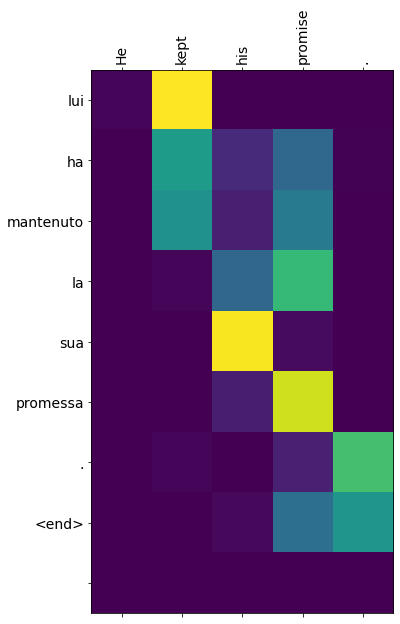

Sample Bleu score ::  0.5946035575013605


In [ ]:
ind = random.sample( make_train_data ,  1 ).pop()
input_sent = cleaned_eng [ ind      ]
result, input_sentence, attention_plot  = predict(  input_sent  )
orig_sent = cleaned_ita[ ind    ]
input_sent = cleaned_eng [ ind      ]
result, input_sentence, attention_plot  = predict(  input_sent  )
orig_sent = cleaned_ita[ ind   ]
print('Input English sentence is :: ', input_sentence)
print( 'Model\'s Translation :: ' , result)
print('Original Italian sentence :: ', orig_sent)
print('Google Translate  of the prediction in english is  :: he kept his promise ' )

plot_attention( attention_plot[  :  len(result.split(' '))  , :  len(input_sentence.split(' ')  )  ] , input_sentence.split() , result.split() )
print( 'Sample Bleu score :: ', bleu.sentence_bleu(orig_sent.split() , result.split() )  ) 

Input English sentence is ::  Tom will find out the truth .
Model's Translation ::  tom trovera la verita . <end> 
Original Italian sentence ::  Tom scoprirà la verità .
Google Translate  of the prediction in english is  :: tom will find the truth. 


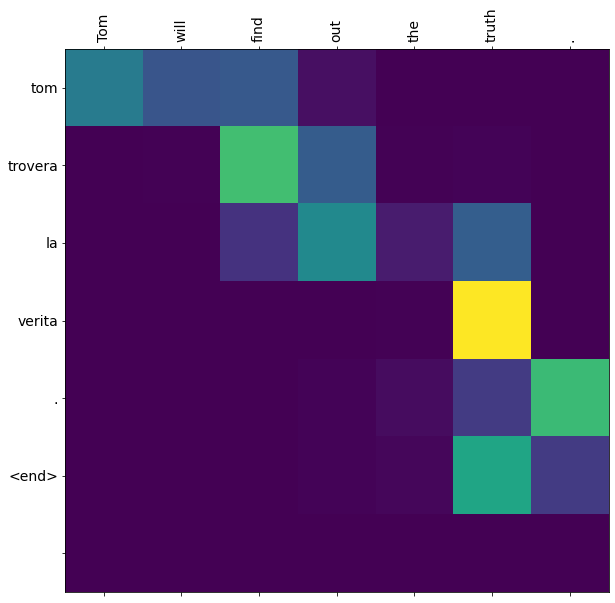

Sample Bleu score ::  0.6389431042462724


In [ ]:
ind = random.sample( make_train_data ,  1 ).pop()
input_sent = cleaned_eng [ ind      ]
result, input_sentence, attention_plot  = predict(  input_sent  )
orig_sent = cleaned_ita[ ind    ]
input_sent = cleaned_eng [ ind      ]
result, input_sentence, attention_plot  = predict(  input_sent  )
orig_sent = cleaned_ita[ ind   ]
print('Input English sentence is :: ', input_sentence)
print( 'Model\'s Translation :: ' , result)
print('Original Italian sentence :: ', orig_sent)
print('Google Translate  of the prediction in english is  :: tom will find the truth. ' )

plot_attention( attention_plot[  :  len(result.split(' '))  , :  len(input_sentence.split(' ')  )  ] , input_sentence.split() , result.split() )
print( 'Sample Bleu score :: ', bleu.sentence_bleu(orig_sent.split() , result.split() )  ) 

Input English sentence is ::  I got your messages .
Model's Translation ::  ho ricevuto i tuoi messaggi . <end> 
Original Italian sentence ::  Ho ricevuto i tuoi messaggi .
Google Translate  of the prediction in english is  :: I have received your messages. 


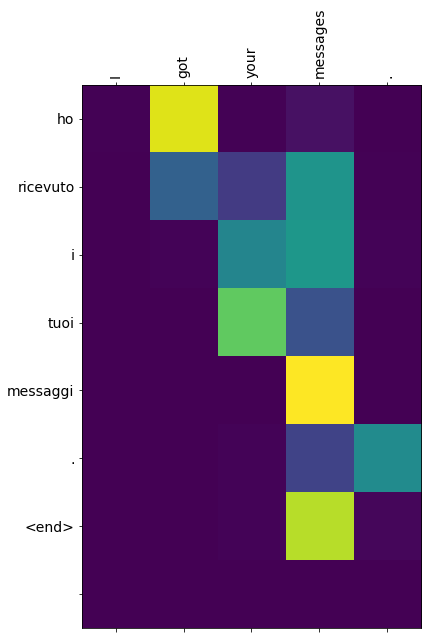

Sample Bleu score ::  0.6337834876616586


In [ ]:
ind = random.sample( make_test_data ,  1 ).pop()
input_sent = cleaned_eng [ ind      ]
result, input_sentence, attention_plot  = predict(  input_sent  )
orig_sent = cleaned_ita[ ind    ]
input_sent = cleaned_eng [ ind      ]
result, input_sentence, attention_plot  = predict(  input_sent  )
orig_sent = cleaned_ita[ ind   ]
print('Input English sentence is :: ', input_sentence)
print( 'Model\'s Translation :: ' , result)
print('Original Italian sentence :: ', orig_sent)
print('Google Translate  of the prediction in english is  :: I have received your messages. ' )

plot_attention( attention_plot[  :  len(result.split(' '))  , :  len(input_sentence.split(' ')  )  ] , input_sentence.split() , result.split() )
print( 'Sample Bleu score :: ', bleu.sentence_bleu(orig_sent.split() , result.split() )  ) 

Input English sentence is ::  The town in which I live is rather small .
Model's Translation ::  la citta in cui abito e piuttosto piccolo . <end> 
Original Italian sentence ::  La città in cui vivo è piuttosto piccola .
Google Translate  of the prediction in english is  ::the city where I live is quite small.


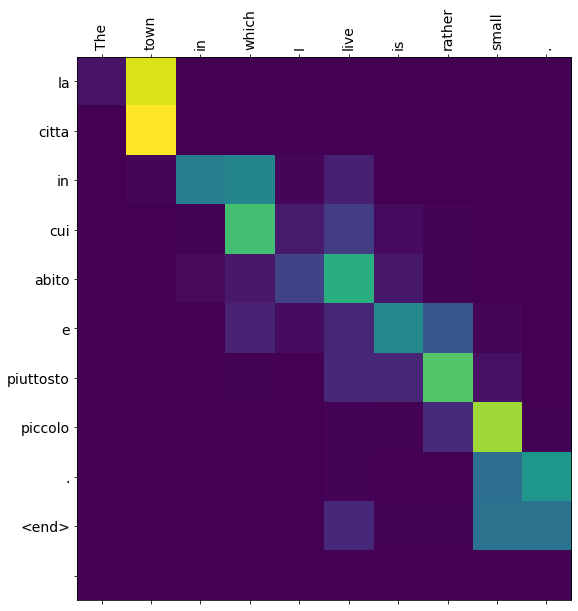

Sample Bleu score ::  0.5623413251903491


In [ ]:
ind = random.sample( make_test_data ,  1 ).pop()
input_sent = cleaned_eng [ ind      ]
result, input_sentence, attention_plot  = predict(  input_sent  )
orig_sent = cleaned_ita[ ind    ]
input_sent = cleaned_eng [ ind      ]
result, input_sentence, attention_plot  = predict(  input_sent  )
orig_sent = cleaned_ita[ ind   ]
print('Input English sentence is :: ', input_sentence)
print( 'Model\'s Translation :: ' , result)
print('Original Italian sentence :: ', orig_sent)
print('Google Translate  of the prediction in english is  ::the city where I live is quite small.' )

plot_attention( attention_plot[  :  len(result.split(' '))  , :  len(input_sentence.split(' ')  )  ] , input_sentence.split() , result.split() )
print( 'Sample Bleu score :: ', bleu.sentence_bleu(orig_sent.split() , result.split() )  ) 

<font color='blue'>**Calculate Average BLEU score for a random of 1000 Sentences**</font>

In [ ]:
rand_integer_arr = random.sample( make_test_data ,  1000 )
rand_integer_arr[:3] , len( rand_integer_arr)

([250499, 66892, 76875], 1000)

In [ ]:
hold_bleau_score = []
for sent in tqdm( rand_integer_arr ): 
  result, input_sentence, attention_weights = predict( cleaned_eng[ sent ] )
  hold_bleau_score.append(  bleu.sentence_bleu(  cleaned_ita[ sent ].split()  , result.split()  )   )

print('Average Bleau score of 1000 test sentences are :: ', sum( hold_bleau_score )/ 1000 ) 


Average Bleau score of 1000 test sentences are ::  0.6354589525940794


**Tensorboard Plots**

In [ ]:
from IPython.display import Image
from IPython.core.display import HTML

In [ ]:
print('Loss over epochs ')
Image(url= 'https://i.imgur.com/8oEXAzQ.png' ) 

Loss over epochs 


In [ ]:
print('Histograms')
Image(url= 'https://i.imgur.com/GM7sp1c.png' ) 

Histograms


## General Model

In [ ]:
# General model
general_model = Encoder_Decoder ( encoder_inputs_length = encoder_inputs_length , decoder_inputs_length = decoder_inputs_length , 
                                                                              input_vocab_size = input_vocab_size ,  output_vocab_size =  output_vocab_size , 
                                                                              score_function = 'general'  , att_units = att_units  )

In [ ]:
# Select model optimizer and loss 
model_optimizer = tf.keras.optimizers.Adam( learning_rate = 0.001  )
general_model.compile(optimizer=model_optimizer  , loss = modified_sparse_cce  )

In [ ]:
import datetime
!rm -rf ./logs/
log_dir="logs/fit1/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True,write_grads=True)

In [ ]:
general_model_history = general_model.fit( x = [  train_eng  ,  train_dec_ita_in ] , y = train_dec_ita_out , callbacks= [ tensorboard_callback],
                                                              steps_per_epoch  = len( train_eng) // 256 ,  batch_size = 256 , epochs = 15 ,
                                                               validation_data = ( [  test_eng  ,  test_dec_ita_in ],  test_dec_ita_out ) , 
                                                              validation_steps = len( test_eng) // 256  
                                 )

Epoch 1/15
1051/1051 [==============================] - 744s 708ms/step - loss: 0.6595 - val_loss: 0.5163
Epoch 2/15
1051/1051 [==============================] - 742s 706ms/step - loss: 0.4216 - val_loss: 0.3493
Epoch 3/15
1051/1051 [==============================] - 744s 708ms/step - loss: 0.2889 - val_loss: 0.2522
Epoch 4/15
1051/1051 [==============================] - 741s 705ms/step - loss: 0.2082 - val_loss: 0.1979
Epoch 5/15
1051/1051 [==============================] - 743s 707ms/step - loss: 0.1609 - val_loss: 0.1663
Epoch 6/15
1051/1051 [==============================] - 742s 706ms/step - loss: 0.1311 - val_loss: 0.1477
Epoch 7/15
1051/1051 [==============================] - 740s 704ms/step - loss: 0.1118 - val_loss: 0.1348
Epoch 8/15
1051/1051 [==============================] - 740s 705ms/step - loss: 0.0980 - val_loss: 0.1267
Epoch 9/15
1051/1051 [==============================] - 740s 705ms/step - loss: 0.0879 - val_loss: 0.1207
Epoch 10/15
1051/1051 [=======================

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs/fit1

In [ ]:
general_model.summary()

Model: "encoder__decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_2 (Encoder)          multiple                  1156544   
_________________________________________________________________
decoder_4 (Decoder)          multiple                  8951922   
Total params: 10,108,466
Trainable params: 10,108,466
Non-trainable params: 0
_________________________________________________________________


**General model results**

Input English sentence is ::  Tom nodded hesitantly .
Model's Translation ::  tom annui con esitazione . <end> 
Original Italian sentence ::  Tom ha annuito con esitazione .
Google Translate  of the prediction in english is  :: tom nodded hesitantly 


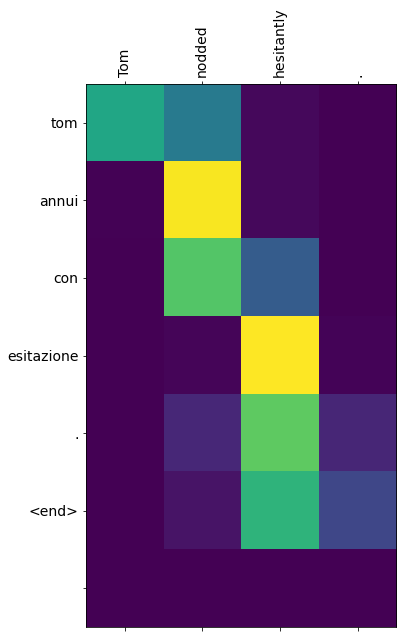

Sample Bleu score ::  0.5408536609893481


In [ ]:
ind = random.sample( make_train_data ,  1 ).pop()
input_sent = cleaned_eng [ ind      ]
result, input_sentence, attention_plot  = predict(  input_sent  )
orig_sent = cleaned_ita[ ind    ]
input_sent = cleaned_eng [ ind      ]
result, input_sentence, attention_plot  = predict(  input_sent  )
orig_sent = cleaned_ita[ ind   ]
print('Input English sentence is :: ', input_sentence)
print( 'Model\'s Translation :: ' , result)
print('Original Italian sentence :: ', orig_sent)
print('Google Translate  of the prediction in english is  :: tom nodded hesitantly ' )

plot_attention( attention_plot[  :  len(result.split(' '))  , :  len(input_sentence.split(' ')  )  ] , input_sentence.split() , result.split() )
print( 'Sample Bleu score :: ', bleu.sentence_bleu(orig_sent.split() , result.split() )  ) 

Input English sentence is ::  Tom is looking for a way to save money .
Model's Translation ::  tom sta cercando un modo per risparmiare soldi . <end> 
Original Italian sentence ::  Tom sta cercando un modo di risparmiare soldi .
Google Translate  of the prediction in english is  :: tom is looking for a way to save money 


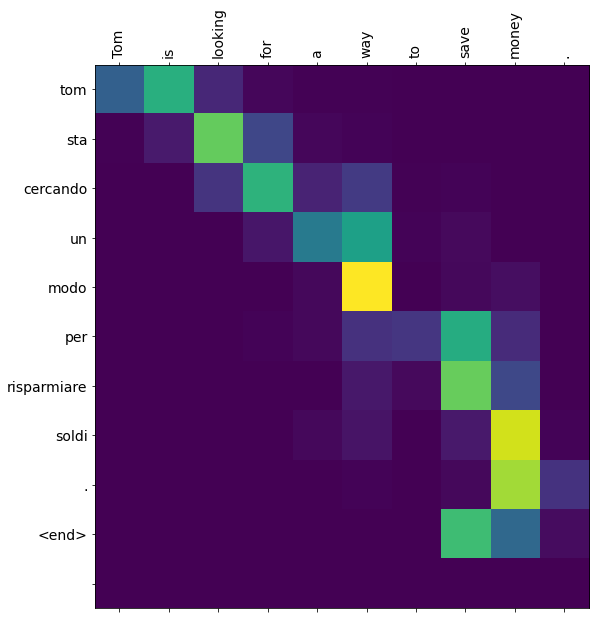

Sample Bleu score ::  0.5088274727401554


In [ ]:
ind = random.sample( make_train_data ,  1 ).pop()
input_sent = cleaned_eng [ ind      ]
result, input_sentence, attention_plot  = predict(  input_sent  )
orig_sent = cleaned_ita[ ind    ]
input_sent = cleaned_eng [ ind      ]
result, input_sentence, attention_plot  = predict(  input_sent  )
orig_sent = cleaned_ita[ ind   ]
print('Input English sentence is :: ', input_sentence)
print( 'Model\'s Translation :: ' , result)
print('Original Italian sentence :: ', orig_sent)
print('Google Translate  of the prediction in english is  :: tom is looking for a way to save money ' )

plot_attention( attention_plot[  :  len(result.split(' '))  , :  len(input_sentence.split(' ')  )  ] , input_sentence.split() , result.split() )
print( 'Sample Bleu score :: ', bleu.sentence_bleu(orig_sent.split() , result.split() )  ) 

Input English sentence is ::  Do you know how this works ?
Model's Translation ::  sai come funziona questo ? <end> 
Original Italian sentence ::  Tu lo sai come funziona questo ?
Google Translate  of the prediction in english is  :: do you know how this works? 


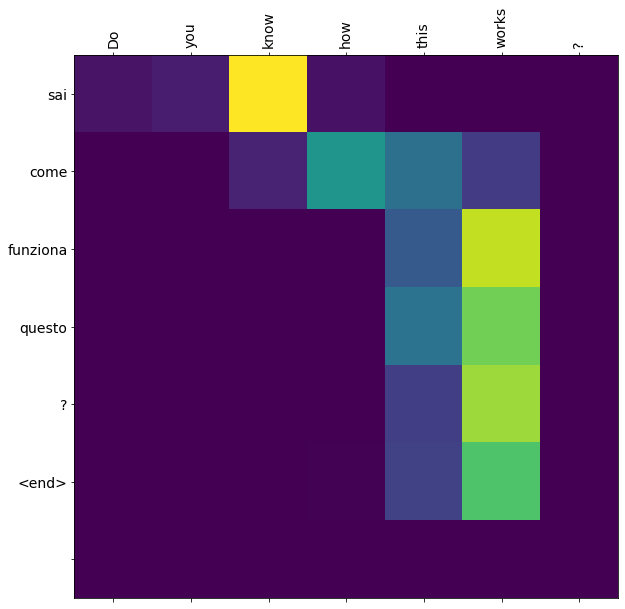

Sample Bleu score ::  0.6389431042462724


In [ ]:
ind = random.sample( make_test_data ,  1 ).pop()
input_sent = cleaned_eng [ ind      ]
result, input_sentence, attention_plot  = predict(  input_sent  )
orig_sent = cleaned_ita[ ind    ]
input_sent = cleaned_eng [ ind      ]
result, input_sentence, attention_plot  = predict(  input_sent  )
orig_sent = cleaned_ita[ ind   ]
print('Input English sentence is :: ', input_sentence)
print( 'Model\'s Translation :: ' , result)
print('Original Italian sentence :: ', orig_sent)
print('Google Translate  of the prediction in english is  :: do you know how this works? ' )

plot_attention( attention_plot[  :  len(result.split(' '))  , :  len(input_sentence.split(' ')  )  ] , input_sentence.split() , result.split() )
print( 'Sample Bleu score :: ', bleu.sentence_bleu(orig_sent.split() , result.split() )  ) 

Input English sentence is ::  Tom takes a shower every morning before breakfast .
Model's Translation ::  tom fa una doccia ogni mattina prima di colazione . <end> 
Original Italian sentence ::  Tom si fa una doccia ogni mattina prima della colazione .
Google Translate  of the prediction in english is  :: Tom takes a shower every morning before breakfast


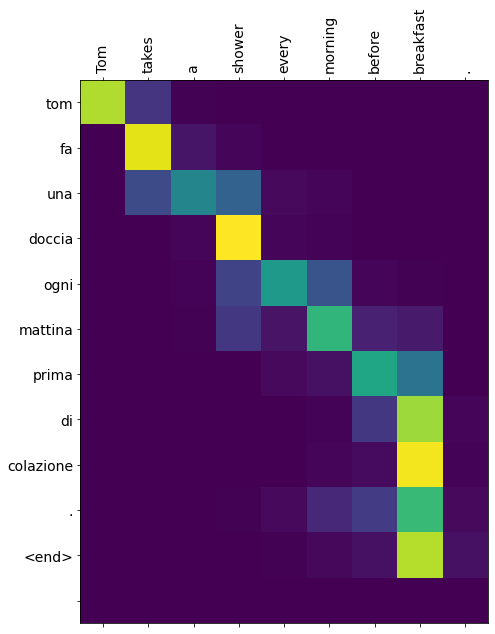

Sample Bleu score ::  0.5491004867761125


In [ ]:
ind = random.sample( make_test_data ,  1 ).pop()
input_sent = cleaned_eng [ ind      ]
result, input_sentence, attention_plot  = predict(  input_sent  )
orig_sent = cleaned_ita[ ind    ]
input_sent = cleaned_eng [ ind      ]
result, input_sentence, attention_plot  = predict(  input_sent  )
orig_sent = cleaned_ita[ ind   ]
print('Input English sentence is :: ', input_sentence)
print( 'Model\'s Translation :: ' , result)
print('Original Italian sentence :: ', orig_sent)
print('Google Translate  of the prediction in english is  :: Tom takes a shower every morning before breakfast' )

plot_attention( attention_plot[  :  len(result.split(' '))  , :  len(input_sentence.split(' ')  )  ] , input_sentence.split() , result.split() )
print( 'Sample Bleu score :: ', bleu.sentence_bleu(orig_sent.split() , result.split() )  ) 

<font color='blue'>**Calculate Average BLEU score for a random of 1000 Sentences for general model**</font>

In [ ]:
rand_integer_arr = random.sample( make_test_data ,  1000 )
rand_integer_arr[:3] , len( rand_integer_arr)

([109984, 33021, 174865], 1000)

In [ ]:
hold_bleau_score = []
for sent in tqdm( rand_integer_arr ): 
  result, input_sentence, attention_weights = predict( cleaned_eng[ sent ] )
  hold_bleau_score.append(  bleu.sentence_bleu(  cleaned_ita[ sent ].split()  , result.split()  )   )

print('Average Bleau score of 1000 test sentences are :: ', sum( hold_bleau_score )/ 1000 ) 


Average Bleau score of 1000 test sentences are ::  0.6358252372835966


**Tensorboard plots**

In [ ]:
print('Loss over epochs :: ')
Image( url = 'https://i.imgur.com/Ni36ELv.png' )

Loss over epochs :: 


In [ ]:
print('Histograms : ')
Image( url = 'https://i.imgur.com/a6r5T02.png' )

Histograms : 


## Concat


In [ ]:
# Concat model
concat_model = Encoder_Decoder ( encoder_inputs_length = encoder_inputs_length , decoder_inputs_length = decoder_inputs_length , 
                                                                              input_vocab_size = input_vocab_size ,  output_vocab_size =  output_vocab_size , 
                                                                              score_function = 'concat'  , att_units = att_units  )

In [ ]:
# Select optimizer and loss
model_optimizer = tf.keras.optimizers.Adam( learning_rate = 0.001  )
concat_model.compile(optimizer=model_optimizer  , loss = modified_sparse_cce  )

In [ ]:
import datetime
!rm -rf ./logs/
log_dir="logs/fit1/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True,write_grads=True)

In [ ]:
concat_model_history = concat_model.fit( x = [  train_eng  ,  train_dec_ita_in ] , y = train_dec_ita_out , callbacks= [ tensorboard_callback],
                                                              steps_per_epoch  = len( train_eng) // 256 ,  batch_size = 256 , epochs = 11 ,
                                                               validation_data = ( [  test_eng  ,  test_dec_ita_in ],  test_dec_ita_out ) , 
                                                              validation_steps = len( test_eng) // 256  
                                 )

Epoch 1/11
1051/1051 [==============================] - 1013s 964ms/step - loss: 0.6961 - val_loss: 0.6047
Epoch 2/11
1051/1051 [==============================] - 1013s 964ms/step - loss: 0.5492 - val_loss: 0.4825
Epoch 3/11
1051/1051 [==============================] - 1008s 959ms/step - loss: 0.4236 - val_loss: 0.3826
Epoch 4/11
1051/1051 [==============================] - 1010s 961ms/step - loss: 0.3346 - val_loss: 0.3062
Epoch 5/11
1051/1051 [==============================] - 1003s 954ms/step - loss: 0.2584 - val_loss: 0.2419
Epoch 6/11
1051/1051 [==============================] - 1011s 962ms/step - loss: 0.1992 - val_loss: 0.1969
Epoch 7/11
1051/1051 [==============================] - 1018s 969ms/step - loss: 0.1587 - val_loss: 0.1685
Epoch 8/11
1051/1051 [==============================] - 1008s 959ms/step - loss: 0.1314 - val_loss: 0.1507
Epoch 9/11
1051/1051 [==============================] - 1009s 960ms/step - loss: 0.1128 - val_loss: 0.1381
Epoch 10/11
1051/1051 [==============

In [ ]:
concat_model_history = concat_model.fit( x = [  train_eng  ,  train_dec_ita_in ] , y = train_dec_ita_out , 
                                                              steps_per_epoch  = len( train_eng) // 256 ,  batch_size = 256 , epochs = 4 ,
                                                               validation_data = ( [  test_eng  ,  test_dec_ita_in ],  test_dec_ita_out ) , 
                                                              validation_steps = len( test_eng) // 256  
                                 )

Epoch 1/4
1051/1051 [==============================] - 966s 919ms/step - loss: 0.0816 - val_loss: 0.1189
Epoch 2/4
1051/1051 [==============================] - 962s 916ms/step - loss: 0.0754 - val_loss: 0.1156
Epoch 3/4
1051/1051 [==============================] - 962s 915ms/step - loss: 0.0704 - val_loss: 0.1138
Epoch 4/4
1051/1051 [==============================] - 961s 914ms/step - loss: 0.0661 - val_loss: 0.1111


In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs/fit1

In [ ]:
concat_model.summary()

Model: "encoder__decoder_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_6 (Encoder)          multiple                  1156544   
_________________________________________________________________
decoder_10 (Decoder)         multiple                  9017715   
Total params: 10,174,259
Trainable params: 10,174,259
Non-trainable params: 0
_________________________________________________________________


**Concat model results**

Input English sentence is ::  Tom participated in the Boston marathon .
Model's Translation ::  tom partecipo alla maratona di boston . <end> 
Original Italian sentence ::  Tom ha partecipato alla maratona di Boston .
Google Translate  of the prediction in english is  :: tom participate in the boston marathon. 


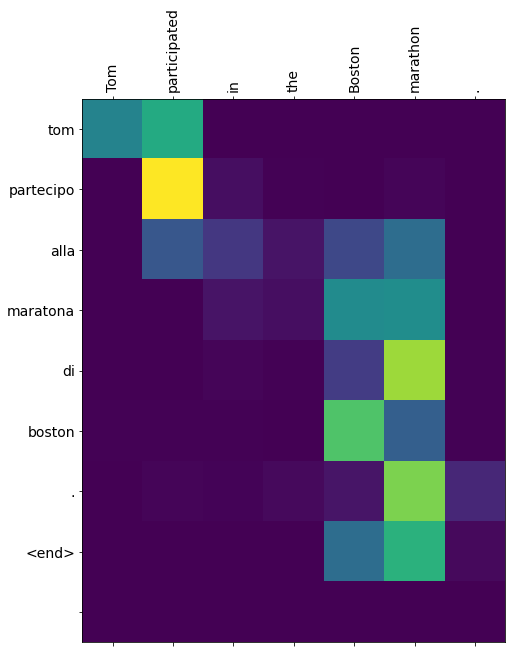

Sample Bleu score ::  0.5946035575013605


In [ ]:
ind = random.sample( make_train_data ,  1 ).pop()
input_sent = cleaned_eng [ ind      ]
result, input_sentence, attention_plot  = predict(  input_sent  )
orig_sent = cleaned_ita[ ind    ]
input_sent = cleaned_eng [ ind      ]
result, input_sentence, attention_plot  = predict(  input_sent  )
orig_sent = cleaned_ita[ ind   ]
print('Input English sentence is :: ', input_sentence)
print( 'Model\'s Translation :: ' , result)
print('Original Italian sentence :: ', orig_sent)
print('Google Translate  of the prediction in english is  :: tom participate in the boston marathon. ' )

plot_attention( attention_plot[  :  len(result.split(' '))  , :  len(input_sentence.split(' ')  )  ] , input_sentence.split() , result.split() )
print( 'Sample Bleu score :: ', bleu.sentence_bleu(orig_sent.split() , result.split() )  ) 

Input English sentence is ::  It took a long time to accustom myself to the noise .
Model's Translation ::  mi volle molto tempo per abituarmi al rumore . <end> 
Original Italian sentence ::  Mi volle molto tempo per abituarmi al rumore .
Google Translate  of the prediction in english is  :: it took me a long time to get used to the noise. 


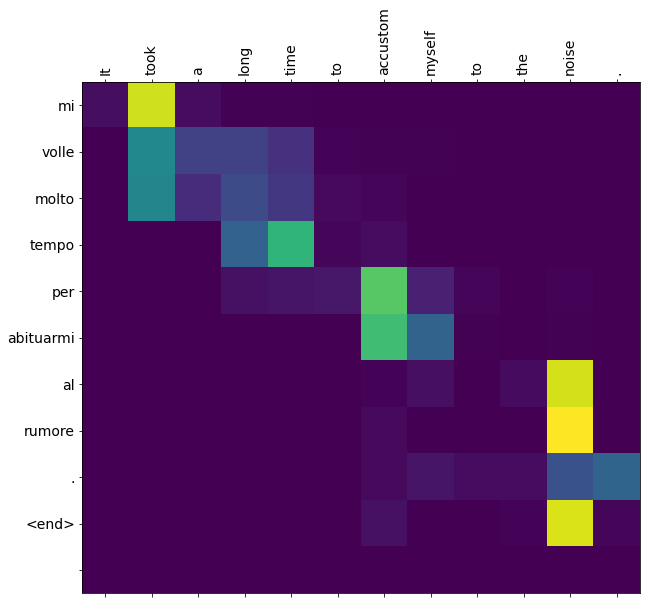

Sample Bleu score ::  0.5623413251903491


In [ ]:
ind = random.sample( make_train_data ,  1 ).pop()
input_sent = cleaned_eng [ ind      ]
result, input_sentence, attention_plot  = predict(  input_sent  )
orig_sent = cleaned_ita[ ind    ]
input_sent = cleaned_eng [ ind      ]
result, input_sentence, attention_plot  = predict(  input_sent  )
orig_sent = cleaned_ita[ ind   ]
print('Input English sentence is :: ', input_sentence)
print( 'Model\'s Translation :: ' , result)
print('Original Italian sentence :: ', orig_sent)
print('Google Translate  of the prediction in english is  :: it took me a long time to get used to the noise. ' )

plot_attention( attention_plot[  :  len(result.split(' '))  , :  len(input_sentence.split(' ')  )  ] , input_sentence.split() , result.split() )
print( 'Sample Bleu score :: ', bleu.sentence_bleu(orig_sent.split(), result.split() )  ) 

Input English sentence is ::  I already told you that she isn't here .
Model's Translation ::  ti ho gia detto che lei e qui . <end> 
Original Italian sentence ::  Vi ho già detto che non è qua .
Google Translate  of the prediction in english is  :: I already told you that she is here. 


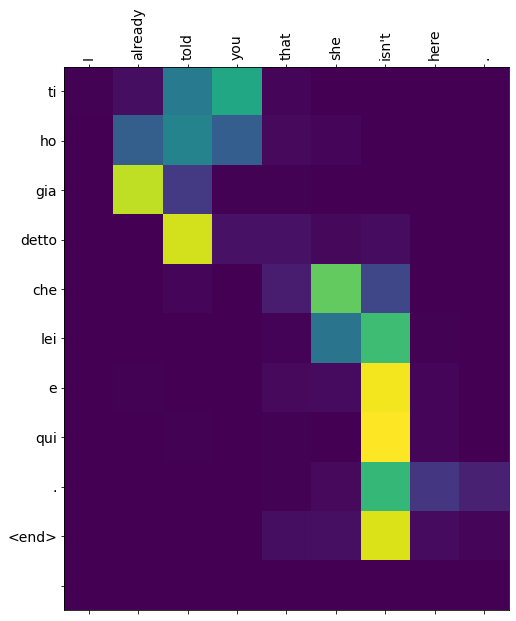

Sample Bleu score ::  0.668740304976422


In [ ]:
ind = random.sample( make_test_data ,  1 ).pop()
input_sent = cleaned_eng [ ind      ]
result, input_sentence, attention_plot  = predict(  input_sent  )
orig_sent = cleaned_ita[ ind    ]
input_sent = cleaned_eng [ ind      ]
result, input_sentence, attention_plot  = predict(  input_sent  )
orig_sent = cleaned_ita[ ind   ]
print('Input English sentence is :: ', input_sentence)
print( 'Model\'s Translation :: ' , result)
print('Original Italian sentence :: ', orig_sent)
print('Google Translate  of the prediction in english is  :: I already told you that she is here. ' )

plot_attention( attention_plot[  :  len(result.split(' '))  , :  len(input_sentence.split(' ')  )  ] , input_sentence.split() , result.split() )
print( 'Sample Bleu score :: ', bleu.sentence_bleu(orig_sent.split(), result.split() )  ) 

Input English sentence is ::  I don't like this camera .
Model's Translation ::  mi piace questa macchina fotografica . <end> 
Original Italian sentence ::  Non mi piace questa macchina fotografica .
Google Translate  of the prediction in english is  :: i like this camera. 


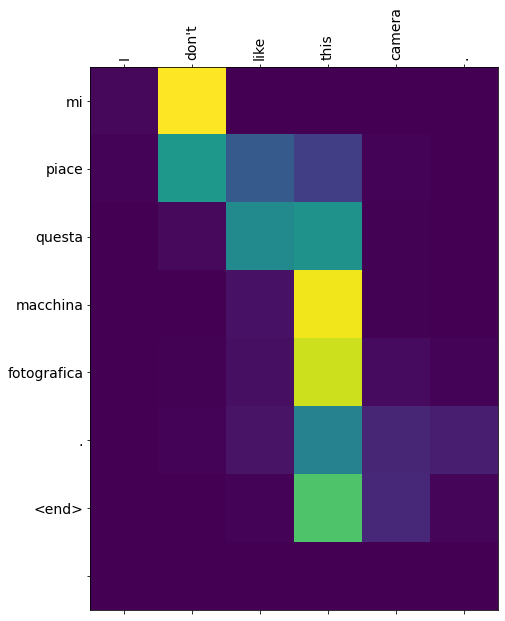

Sample Bleu score ::  0.6147881529512643


In [ ]:
ind = random.sample( make_test_data ,  1 ).pop()
input_sent = cleaned_eng [ ind      ]
result, input_sentence, attention_plot  = predict(  input_sent  )
orig_sent = cleaned_ita[ ind    ]
input_sent = cleaned_eng [ ind      ]
result, input_sentence, attention_plot  = predict(  input_sent  )
orig_sent = cleaned_ita[ ind   ]
print('Input English sentence is :: ', input_sentence)
print( 'Model\'s Translation :: ' , result)
print('Original Italian sentence :: ', orig_sent)
print('Google Translate  of the prediction in english is  :: i like this camera. ' )

plot_attention( attention_plot[  :  len(result.split(' '))  , :  len(input_sentence.split(' ')  )  ] , input_sentence.split() , result.split() )
print( 'Sample Bleu score :: ', bleu.sentence_bleu(orig_sent.split(), result.split() )  ) 

Input English sentence is ::  He paid no attention to my warning .
Model's Translation ::  non ha prestato attenzione al mio avviso . <end> 
Original Italian sentence ::  ['Non', 'ha', 'prestato', 'attenzione', 'al', 'mio', 'avviso', '.']
Google Translate  of the prediction in english is  :: did not pay attention to my notice. 


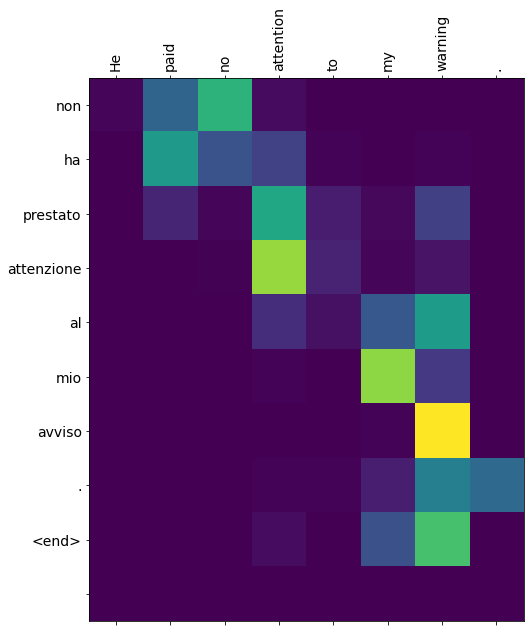

Sample Bleu score ::  0.5773502691896257


In [ ]:
ind = random.sample( make_test_data ,  1 ).pop()
input_sent = cleaned_eng [ ind      ]
result, input_sentence, attention_plot  = predict(  input_sent  )
orig_sent = cleaned_ita[ ind    ].split()
input_sent = cleaned_eng [ ind      ]
result, input_sentence, attention_plot  = predict(  input_sent  )
orig_sent = cleaned_ita[ ind   ].split()
print('Input English sentence is :: ', input_sentence)
print( 'Model\'s Translation :: ' , result)
print('Original Italian sentence :: ', orig_sent)
print('Google Translate  of the prediction in english is  :: did not pay attention to my notice. ' )

plot_attention( attention_plot[  :  len(result.split(' '))  , :  len(input_sentence.split(' ')  )  ] , input_sentence.split() , result.split() )
print( 'Sample Bleu score :: ', bleu.sentence_bleu(orig_sent, result.split() )  ) 

<font color='blue'>**Calculate Average BLEU score for a random of 1000 Sentences for Concat model**</font>

In [ ]:
rand_integer_arr = random.sample( make_test_data ,  1000 )
rand_integer_arr[:3] , len( rand_integer_arr)

([50147, 41071, 42391], 1000)

In [ ]:
hold_bleau_score = []
for sent in tqdm( rand_integer_arr ): 
  result, input_sentence, attention_weights = predict( cleaned_eng[ sent ] )
  hold_bleau_score.append(  bleu.sentence_bleu(  cleaned_ita[ sent ].split()  , result.split()  )   )

print('Average Bleau score of 1000 test sentences are :: ', sum( hold_bleau_score )/ 1000 ) 


Average Bleau score of 1000 test sentences are ::  0.6445029711378037


In [ ]:
**Tensorboard plots**


In [ ]:
print('loss over epochs :: ')
Image( url = 'https://i.imgur.com/JxVfk0h.png')

loss over epochs :: 


In [ ]:
print('Histograms :: ')
Image( url = 'https://i.imgur.com/H5bMwbN.png')

Histograms :: 


In [ ]:
### Observations ::

###### Dot
* We can see that , by taking the dot product we are calulating some sort of similarty measure, between the decoder hiddenstate and the encoder states, 
    This is particularly useful when both encoder and decoder hidden state are of the same dimension. Dot scoring function is quickest to calculate , as there is only 
    one operation, which is multiplication. One of the disadvantages of this is that , there is no limiting factor for the gradient , there are chances for them to become
    big.**In order to deal with the gradient issue, another variation of the Dot function , i.e Scaled Dot score is used, which is Dot( hs, ht ) / sqrt( n )** 

###### General  ( Or  Multiplicative Score function)
* Here, it is essentially the  **Dot**  score , but with a Weight matrix in between, which does some sort of weighing to the encoder output, this matrix is learnt through
   Backpropagation .  The same problem of Gradients becoming big still exists here. But Since there is learnable matrix W_alpha, we can expect the model to perform 
   better than the simple **Dot** Scoring function.

###### Concat 
*  Similar to the general function , here , we have a weight matrix , which is applied after concatenating the encoder output and 
    decoder  hiddenstate ,  and then tanh is applied  followed by a single Multilayer perceptron layer. Since we are using tanh, we can now be sure 
    that the gradient values are limited , thus not allowing it to become very huge or small.

##### Additional observations of results ( all scoring functions combined ) ::

* We can see now that the Concat performs better than general and general performs better than Dot as expected , because 
    There are additional weight matrices in both general and concat functions, but the difference in performance is  very small.
    
    
* We also notice that the model learns to insert question marks and punctuation marks for some sentences, also , the model is not able to regenerate certain
   words with **accent eg :  José  has a different pronounciation than Jose , the last character has an accent, which model could not replicate correctly**
                
                
* The model fails to understand the  meaning of the sentence in certain instances , 
    eg : The input sentence in english  **I don't like Camera after translating to italian , converted to english gives  'I like Camera'** which is clearly wrong.

#### Further Improvements that can be made ::

* Instead of training the embedding layer, we can use **pretrained Glove or other vectors**  to represent both Italian and English words , results might be more accurate.


* Instead of a single Lstm layer, we can also use **Bidirectional RNN/LSTM  , we can also use Stacked LSTMS  .**

These are some ideas which might improve the results.

In [ ]:
## References 

1)  https://www.tensorflow.org/tutorials/text/nmt_with_attention
    
2) https://stackoverflow.com/questions/57253841/from-logits-true-and-from-logits-false-get-different-training-result-for-tf-loss

3) https://github.com/tensorflow/tensorflow/issues/29545

4) https://stackoverflow.com/questions/56904476/how-to-clear-gpu-memory-without-restarting-runtime-in-google-colaboratory-tenso

5) http://thoughtsondl.blogspot.com/2018/06/how-to-release-or-reset-gpu-memory-in.html

6) https://arxiv.org/abs/1508.04025

7) https://arxiv.org/abs/1508.04025

8) https://www.youtube.com/watch?v=nA08C0RL9kA&list=PLHVv_Q5Gh-7ik2yLt56F05c7ZoLtQiXCy&index=7

9) https://stackoverflow.com/questions/34240703/what-is-logits-softmax-and-softmax-cross-entropy-with-logits?rq=1

10) https://www.youtube.com/watch?v=FMXUkEbjf9k